# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

# Try reweighting BCE loss with class weights

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch
import torch.nn as nn

import random

import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from skorch import NeuralNetRegressor,NeuralNetClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [3]:
set_seed(46)

Random seed set as 46


## Load data

In [4]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


locus_tag  gene                                 product type  strand  start  \
0     b0005  yaaX  DUF2502 domain-containing protein YaaX  CDS       1   5233   
1     b0007  yaaJ               putative transporter YaaJ  CDS      -1   6528   
2     b0008  talB                         transaldolase B  CDS       1   8237   
3     b0009   mog       molybdopterin adenylyltransferase  CDS       1   9305   
4     b0010  satP        acetate/succinate:H(+) symporter  CDS      -1   9927   

                                     upstream_region         0         1  \
0  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0.008229 -0.000685   
1  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0.008111 -0.003929   
2  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0.008629 -0.001270   
3  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0.002952  0.002053   
4  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0.006142  0.000884   

          2  ...        82        83        84        85        86        87  \
0 -0.005215  ... -0.006856  0.010676  0.008874  0.018497  0.000700 -0.013267   
1  0.003207  ... -0.000337 -0.010468  0.016122  0.010361 -0.003899 -0.022839   
2 -0.005664  ...  0.000394  0.007215 -0.000707 -0.012959 -0.002329  0.006391   
3 -0.002882  ... -0.009291 -0.000226  0.016013  0.002179  0.004891 -0.002365   
4  0.008166  ... -0.009214 -0.010588  0.001363  0.003979 -0.005208  0.003190   

         88        89        90        91  
0  0.015265  0.016886 -0.015319 -0.020727  
1 -0.003665 -0.001823 -0.023604 -0.012765  
2 -0.003650 -0.008537  0.002898 -0.000891  
3 -0.003490 -0.006066 -0.011982  0.011477  
4 -0.015137 -0.005784 -0.001302  0.010800  

[5 rows x 99 columns]

TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [5]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = [x.strip() for x in M.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [6]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

0  1  2  3  4  5  6  7  8  9  ...  82  83  84  85  86  87  88  89  \
locus_tag                                ...                                   
b0002      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0003      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0004      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0005      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0006      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
...       .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
b4688      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4693      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_1    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_2    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4705      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

           90  91  
locus_tag          
b0002       0   0  
b0003       0   0  
b0004       0   0  
b0005       0   0  
b0006       0   0  
...        ..  ..  
b4688       0   0  
b4693       0   0  
b4696_1     0   0  
b4696_2     0   0  
b4705       0   0  

[3923 rows x 92 columns]

In [7]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  82  83  84  85  86  87  88  89  90  91  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 99 columns]

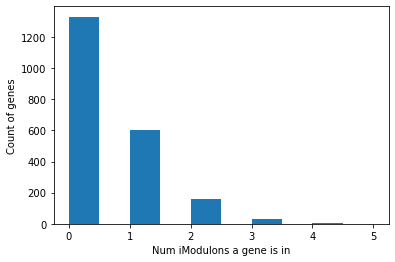

In [8]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Filter out uninformative iModulons (and genes?)
* Some iModulons have too few genes to learn from. Get rid of any less than 5. (after filtering out for genes in operons)
* Some genes aren't in any iModulons. Are those worth excluding too?

In [9]:
# make a list of imodulons above a certain threshold
thresh = 20
#mbc = dict([(Mb.iloc[i].name,sum(Mb.iloc[i])) for i in range(Mb.shape[0])])
XYim = XYb[imods]
mbc = dict([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])])
imods_filt = [x for x in mbc if mbc[x]>thresh]
print(f"num iMods that pass threshold of {thresh}:",len(imods_filt))

num iMods that pass threshold of 20: 15


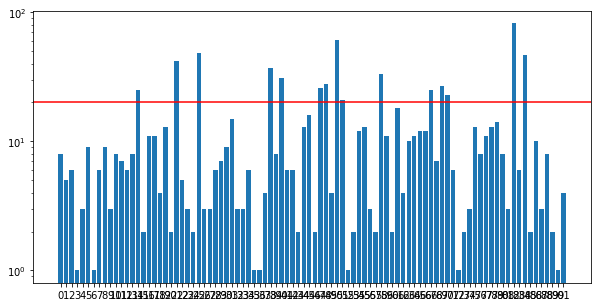

In [10]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods,[mbc[x] for x in imods])
plt.axhline(thresh,c='r')
plt.yscale("log")

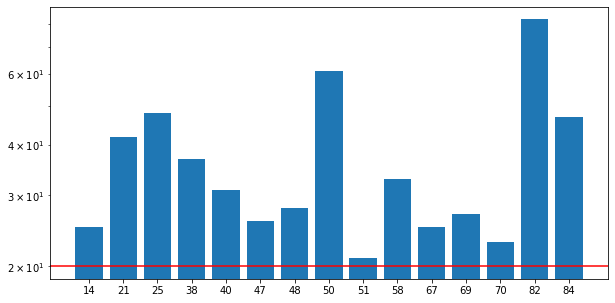

In [11]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods_filt,[mbc[x] for x in imods_filt])
plt.axhline(thresh,c='r')
plt.yscale("log")


In [12]:
# these iMods seem too small to meaningfully try to predict
# (some are single-gene iMods)
imods_exclude = [x for x in mbc if mbc[x]<=thresh]
print(f"num iMods filtered out b/c fewer than {thresh+1} genes: {len(imods_exclude)}")

num iMods filtered out b/c fewer than 21 genes: 77


In [13]:
# drop excluded iMods and keep binary labels
XY = XYb.drop(imods_exclude,axis=1)
XY

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  14  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...   0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...   0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...   0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...   0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...   0   
...      ...      ...                                                ...  ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...   0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...   0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...   0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...   0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...   0   

      21  25  ...  47  48  50  51  58  67  69  70  82  84  
0      0   0  ...   0   0   0   0   0   0   0   0   0   0  
1      0   0  ...   0   0   0   0   0   0   0   0   0   0  
2      0   0  ...   0   0   0   0   0   0   0   0   0   0  
3      0   0  ...   0   0   0   0   0   0   0   0   0   0  
4      0   0  ...   0   0   0   0   0   0   0   0   0   0  
...   ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124   0   0  ...   0   0   0   0   0   0   0   0   0   0  
2125   0   0  ...   0   0   0   0   0   0   0   0   0   0  
2126   0   0  ...   0   0   0   0   0   0   0   0   0   0  
2127   0   0  ...   0   0   0   0   0   0   0   0   0   0  
2128   0   0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 22 columns]

## stratified splitting

In [14]:
def count_imod_train_test_labels(imods,ytr,yte):
    '''
    Given a train and test set of y labels, count how many trues
    are in each imodulon for each split
    '''
    # loop through each train example and count True labels for each imodulon
    imc_train = torch.tensor([0 for x in range(ytr.shape[1])])
    for s in ytr:
        imc_train += s.long()

    # loop through each test example and count True labels for each imodulon
    imc_test = torch.tensor([0 for x in range(yte.shape[1])])
    for s in yte:
        imc_test += s.long()
    
    # print warning for missing examples
    for i,im in enumerate(imods):
        if imc_train[i] == 0:
            print(f"WARNING: iMod {im} train set missing True example.")
        if imc_test[i] == 0:
            print(f"WARNING: iMod {im} test set missing True example.")
            
    # make sure the len of these imod vectors is the same
    assert len(imc_train) == len(imc_test) == len(imods)

    # stack into a pandas df, melt it, plot it
    ts = np.array(torch.stack((torch.tensor([int(x) for x in imods]), imc_train, imc_test)).T)
    imc_df = pd.DataFrame(data=ts,columns=['imod','train_count','test_count'])
    imc_df_melt = imc_df.melt(id_vars=['imod'],value_vars=['train_count','test_count'],var_name='split',value_name='count')
    
    # plot stuff
    plt.figure(figsize=(20,5))
    sns.barplot(data=imc_df_melt, x='imod', y='count', hue='split')
    #plt.yscale('log')
    
    #return imc_df_melt

def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [15]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods_filt)
print("\nX:",X.shape)
print("y:",y.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 15])


In [16]:
from skmultilearn.model_selection import iterative_train_test_split


In [17]:
Xfull_train_strat, yfull_train_strat, Xtest_strat, ytest_strat = iterative_train_test_split(X, y, test_size = 0.2)
Xtrain_strat, ytrain_strat, Xval_strat, yval_strat = iterative_train_test_split(Xfull_train_strat, yfull_train_strat, test_size = 0.2)


In [29]:
yfull_train_strat

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

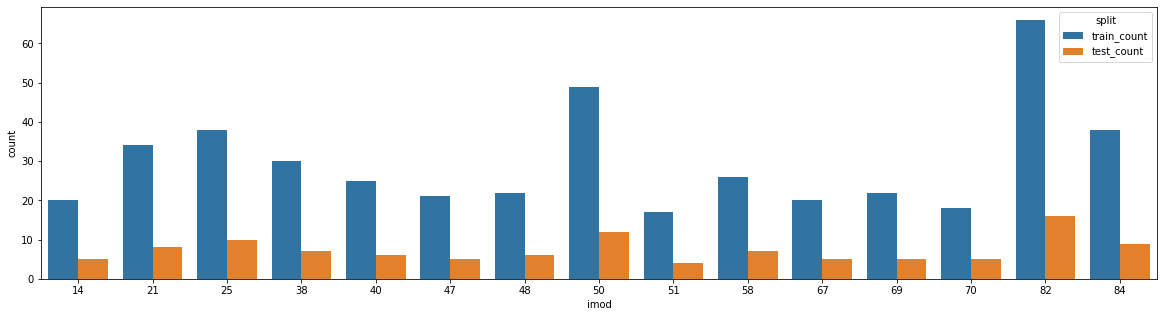

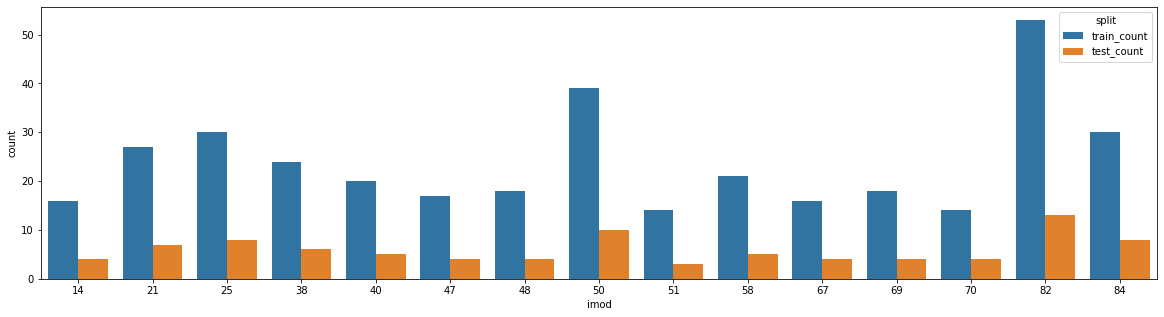

In [30]:
count_imod_train_test_labels(imods_filt,yfull_train_strat,ytest_strat)
count_imod_train_test_labels(imods_filt,ytrain_strat,yval_strat)

## pick some params

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [33]:
y.shape

torch.Size([2129, 15])

In [34]:
from skorch.dataset import ValidSplit

In [35]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_val = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [36]:
ytrain_strat.shape

torch.Size([1362, 15])

In [37]:
net_strat_val.fit(Xtrain_strat, ytrain_strat)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2841       0.7478        0.1442  0.2342
      2        0.1163       0.7478        0.0943  0.2346
      3        0.0921       0.7478        0.0885  0.2345
      4        0.0882       0.7478        0.0871  0.2436
      5        0.0875       0.7478        0.0860  0.2368
      6        0.0865       0.7478        0.0863  0.2349
      7        0.0874       0.7478        0.0859  0.2368
      8        0.0867       0.7478        0.0858  0.2377
      9        0.0867       0.7478        0.0860  0.2388
     10        0.0865       0.7478        0.0859  0.2348
     11        0.0865       0.7478        0.0858  0.2347
     12        0.0864       0.7478        0.0862  0.2347
     13        0.0862       0.7478        0.0857  0.2388
     14        0.0861       0.7478        0.0858  0.2370
     15        0.0861       0.7478        0.0857  0.2365
     16        0.0862       0.7

    129        0.0006       0.7302        0.3372  0.1381
    130        0.0007       0.7067        0.3050  0.1380
    131        0.0005       0.7185        0.3162  0.1412
Stopping since valid_loss has not improved in the last 100 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=15, bias=True)
    )
  ),
)

# Viz model results

In [38]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
    # val acc plot
    fig2 = plt.figure(figsize=(10,2))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        valid_acc = net.history[:, 'valid_acc']
        plt.plot(valid_acc,'--',color=f"C{i}", label=f"{name} Val Acc")
    
    plt.ylim(0,1)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("Valid Accuracy",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color=alt.Color('score:Q',scale=alt.Scale(domain=(0.0,1.0))),
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def view_cls_report(sk_model,Xs,ys,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    print(y_preds.shape)
    print(y_preds)
    
    print(imods)
    cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
    
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    display(cls_df)
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    
    

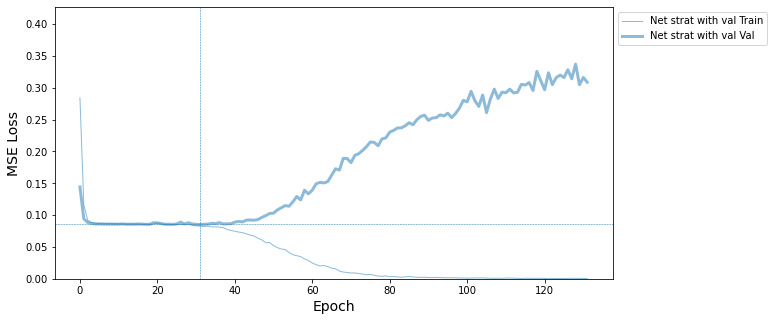

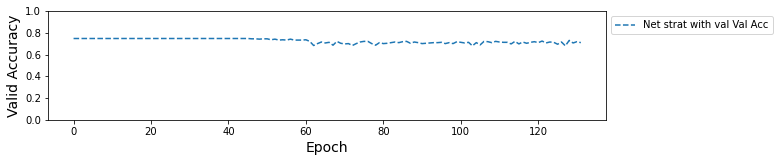

In [39]:
nets = [
    (net_strat_val,'Net strat with val'),
]

sk_loss_plot(nets)

In [40]:
#plot_confusion_multi(nets, Xval_strat,yval_strat,imods_filt)

In [41]:
cls_full_train_df = view_cls_report(net_strat_val,Xtrain_strat,ytrain_strat,imods_filt)
cls_val_df = view_cls_report(net_strat_val,Xval_strat,yval_strat,imods_filt)

(1362, 15)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['14', '21', '25', '38', '40', '47', '48', '50', '51', '58', '67', '69', '70', '82', '84']


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score  support
14             1.000000  1.000000  1.000000       16
21             1.000000  1.000000  1.000000       27
25             1.000000  1.000000  1.000000       30
38             1.000000  1.000000  1.000000       24
40             1.000000  1.000000  1.000000       20
47             1.000000  1.000000  1.000000       17
48             1.000000  1.000000  1.000000       18
50             1.000000  1.000000  1.000000       39
51             1.000000  1.000000  1.000000       14
58             1.000000  1.000000  1.000000       21
67             1.000000  1.000000  1.000000       16
69             1.000000  1.000000  1.000000       18
70             1.000000  1.000000  1.000000       14
82             1.000000  1.000000  1.000000       53
84             1.000000  1.000000  1.000000       30
micro avg      1.000000  1.000000  1.000000      357
macro avg      1.000000  1.000000  1.000000      357
weighted avg   1.000000  1.000000  1.000000      357
samples avg    0.212188  0.212188  0.212188      357

alt.VConcatChart(...)

(341, 15)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['14', '21', '25', '38', '40', '47', '48', '50', '51', '58', '67', '69', '70', '82', '84']


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score  support
14             0.000000  0.000000  0.000000        4
21             0.000000  0.000000  0.000000        7
25             0.000000  0.000000  0.000000        8
38             0.000000  0.000000  0.000000        6
40             0.000000  0.000000  0.000000        5
47             0.000000  0.000000  0.000000        4
48             0.000000  0.000000  0.000000        4
50             0.000000  0.000000  0.000000       10
51             0.000000  0.000000  0.000000        3
58             0.000000  0.000000  0.000000        5
67             0.000000  0.000000  0.000000        4
69             0.000000  0.000000  0.000000        4
70             0.000000  0.000000  0.000000        4
82             0.111111  0.076923  0.090909       13
84             0.000000  0.000000  0.000000        8
micro avg      0.037037  0.011236  0.017241       89
macro avg      0.007407  0.005128  0.006061       89
weighted avg   0.016230  0.011236  0.013279       89
samples avg    0.002933  0.002933  0.002933       89

alt.VConcatChart(...)

In [28]:
cls_val_df

imod  precision  recall  f1-score  support
0     14        0.0     0.0       0.0        4
1     21        0.0     0.0       0.0        7
2     25        0.0     0.0       0.0        8
3     38        0.0     0.0       0.0        6
4     40        0.0     0.0       0.0        5
5     47        0.0     0.0       0.0        4
6     48        0.0     0.0       0.0        4
7     50        0.0     0.0       0.0       10
8     51        0.0     0.0       0.0        3
9     58        0.0     0.0       0.0        5
10    67        0.0     0.0       0.0        4
11    69        0.0     0.0       0.0        4
12    70        0.0     0.0       0.0        4
13    82        0.0     0.0       0.0       13
14    84        0.0     0.0       0.0        8

## BCEwithlogitsloss reweighting?

In [32]:
def get_class_counts(ys):
    '''
    Given a list of iMod vector labels, sum the number of
    positive examples for each iModulon
    '''
    y_sum = torch.tensor(np.zeros(ys.shape[1]))
    for ex in ys:
        y_sum += ex

    return y_sum

# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/11?u=crypdick
def get_pos_weights(ys):
    '''
    Determine loss reweighting vector by the inverse of the positive
    examples for each iMod task
    '''
    class_counts = get_class_counts(ys)
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(ys)-pos_count for pos_count in class_counts]  # <-- HERE 
    
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        print(f"{cdx}| pos:{pos_count}  neg:{neg_count}")
        print("val:", neg_count / (pos_count + 1e-5))
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)
        

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [33]:
bce_pos_weights = get_pos_weights(y)

0| pos:25.0  neg:2104.0
val: tensor(84.1600, dtype=torch.float64)
1| pos:42.0  neg:2087.0
val: tensor(49.6905, dtype=torch.float64)
2| pos:48.0  neg:2081.0
val: tensor(43.3542, dtype=torch.float64)
3| pos:37.0  neg:2092.0
val: tensor(56.5405, dtype=torch.float64)
4| pos:31.0  neg:2098.0
val: tensor(67.6774, dtype=torch.float64)
5| pos:26.0  neg:2103.0
val: tensor(80.8846, dtype=torch.float64)
6| pos:28.0  neg:2101.0
val: tensor(75.0357, dtype=torch.float64)
7| pos:61.0  neg:2068.0
val: tensor(33.9016, dtype=torch.float64)
8| pos:21.0  neg:2108.0
val: tensor(100.3809, dtype=torch.float64)
9| pos:33.0  neg:2096.0
val: tensor(63.5151, dtype=torch.float64)
10| pos:25.0  neg:2104.0
val: tensor(84.1600, dtype=torch.float64)
11| pos:27.0  neg:2102.0
val: tensor(77.8518, dtype=torch.float64)
12| pos:23.0  neg:2106.0
val: tensor(91.5652, dtype=torch.float64)
13| pos:82.0  neg:2047.0
val: tensor(24.9634, dtype=torch.float64)
14| pos:47.0  neg:2082.0
val: tensor(44.2979, dtype=torch.float64)


In [34]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [35]:
net_strat_bcew.fit(Xtrain_strat, ytrain_strat)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3739       0.0000        1.3565  0.2522
      2        1.3672       0.0000        1.3566  0.1712
      3        1.3660       0.0000        1.3564  0.1420
      4        1.3662       0.0000        1.3561  0.1422
      5        1.3650       0.0000        1.3559  0.1429
      6        1.3640       0.0000        1.3550  0.1436
      7        1.3622       0.0000        1.3538  0.1423
      8        1.3570       0.0000        1.3508  0.1421
      9        1.3513       0.0000        1.3469  0.1405
     10        1.3384       0.0000        1.3406  0.1397
     11        1.3162       0.0029        1.3367  0.1421
     12        1.2884       0.0000        1.3637  0.1421
     13        1.2614       0.0088        1.3438  0.1425
     14        1.2403       0.0117        1.3625  0.1427
     15        1.1917       0.0674        1.5132  0.1427
     16        1.1816       0.0

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=15, bias=True)
    )
  ),
)

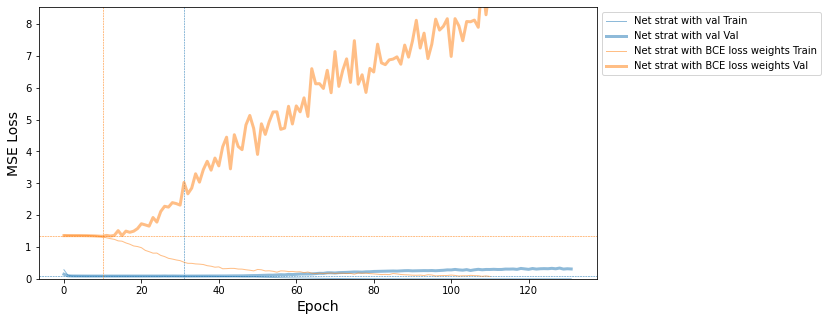

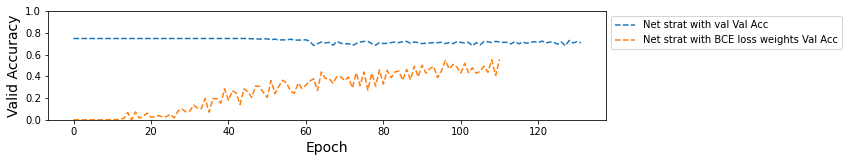

In [36]:
nets = [
    (net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights')
]

sk_loss_plot(nets,yscaler=100)

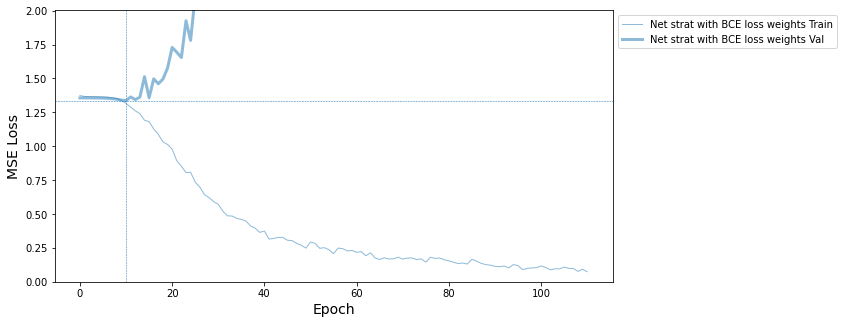

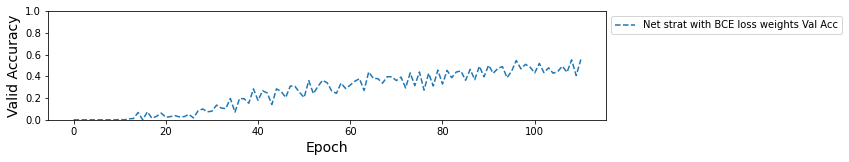

In [37]:

sk_loss_plot([(net_strat_bcew,'Net strat with BCE loss weights')],yscaler=1.5)

In [38]:
cls_full_train_df = view_cls_report(net_strat_bcew,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew,Xval_strat,yval_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

Running Net strat with BCE loss weights


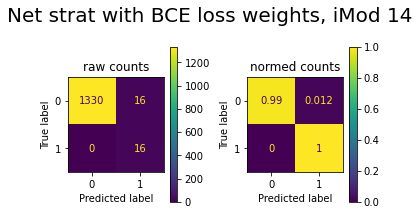

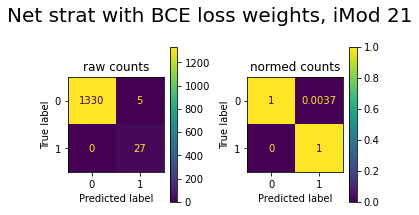

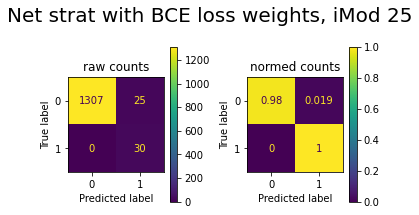

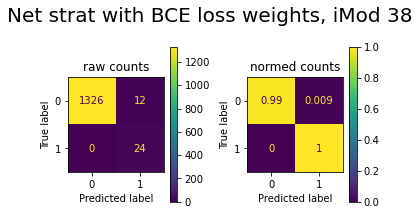

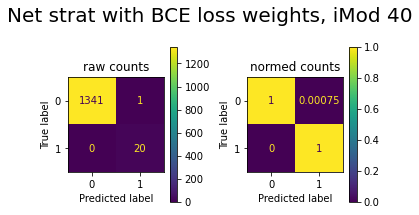

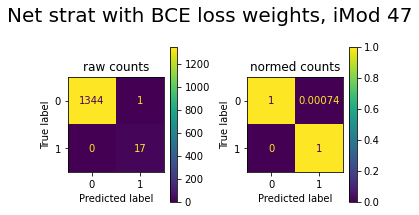

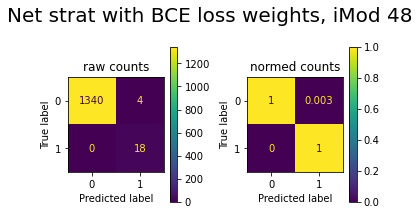

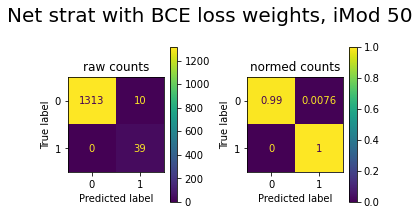

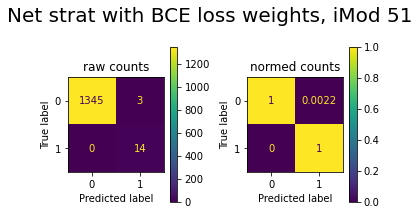

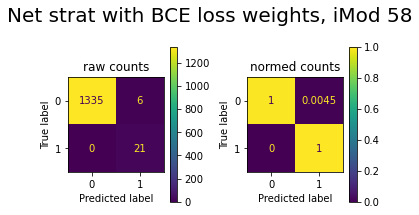

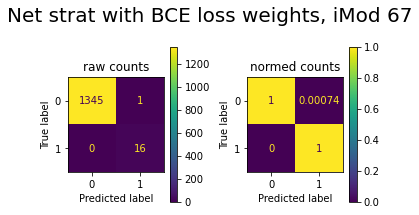

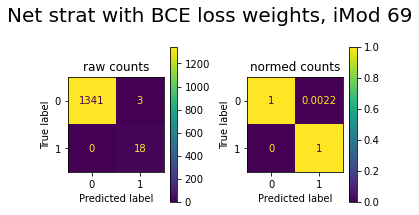

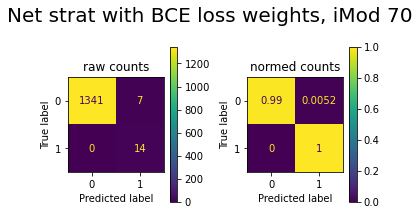

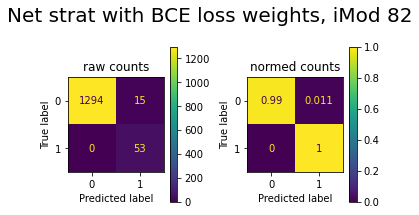

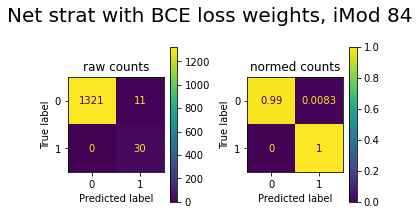

In [39]:
plot_confusion_multi([(net_strat_bcew,'Net strat with BCE loss weights')], Xtrain_strat,ytrain_strat,imods_filt)

Running Net strat with BCE loss weights


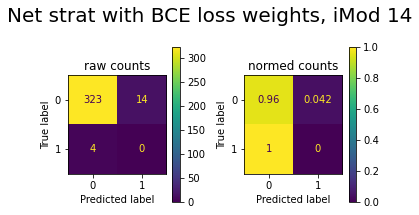

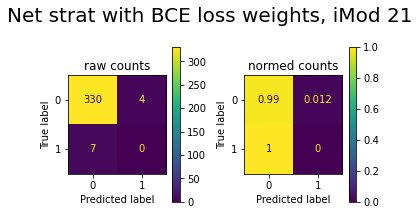

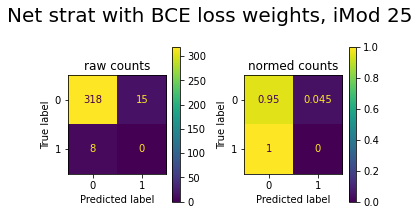

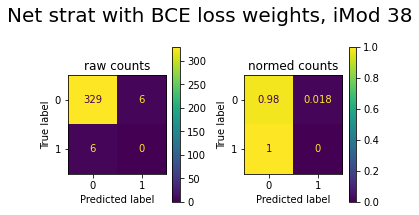

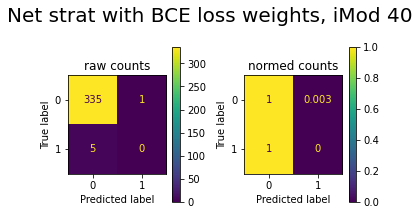

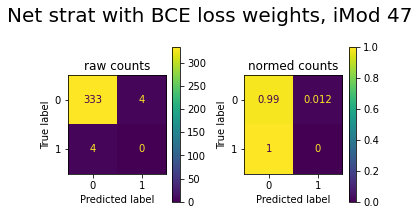

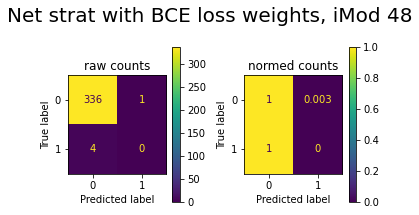

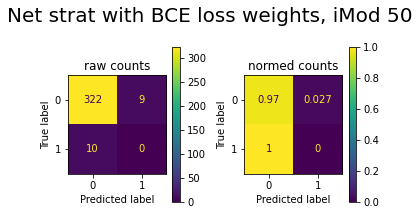

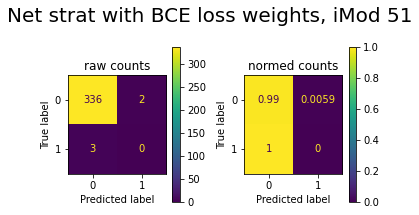

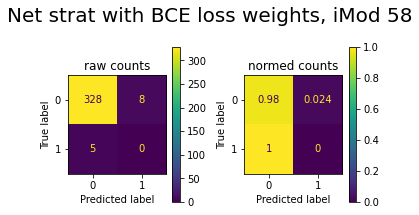

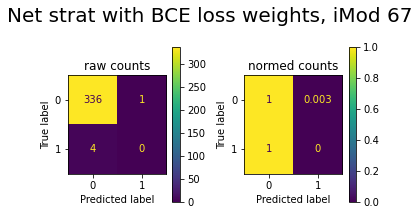

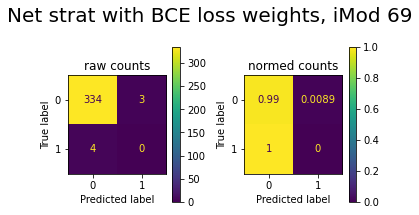

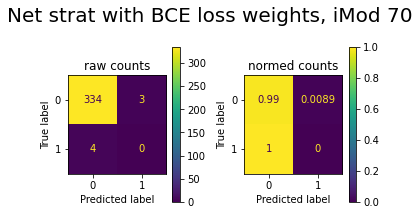

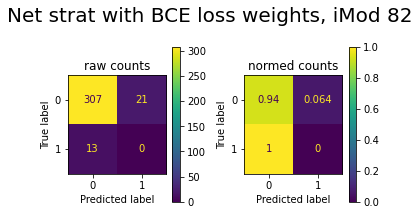

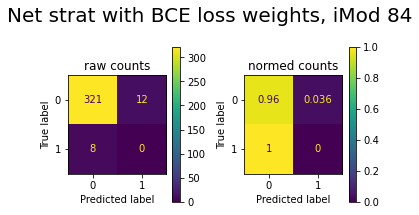

In [40]:
plot_confusion_multi([(net_strat_bcew,'Net strat with BCE loss weights')], Xval_strat,yval_strat,imods_filt)

## fiddle with params with bce weights

In [41]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew_tink5 = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=256,
    module__num_filters2=128,
    module__kernel_size1=16,
    module__kernel_size2=3,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=5000,
    lr=0.0001,
    batch_size=256,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=3000),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [42]:
net_strat_bcew_tink5.fit(Xtrain_strat,ytrain_strat)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3669       0.0000        1.3580  0.3089
      2        1.3644       0.0000        1.3580  0.1678
      3        1.3623       0.0000        1.3581  0.1681
      4        1.3594       0.0000        1.3578  0.1673
      5        1.3562       0.0000        1.3582  0.1678
      6        1.3516       0.0000        1.3579  0.1669
      7        1.3456       0.0000        1.3580  0.1680
      8        1.3409       0.0000        1.3592  0.1676
      9        1.3336       0.0000        1.3580  0.1667
     10        1.3272       0.0000        1.3589  0.1672
     11        1.3189       0.0000        1.3582  0.1679
     12        1.3090       0.0000        1.3580  0.1681
     13        1.3021       0.0000        1.3564  0.1676
     14        1.2909       0.0000        1.3590  0.1676
     15        1.2749       0.0000        1.3563  0.1667
     16        1.2616       0.0

    123        0.1212       0.3900        4.8696  0.1711
    124        0.1136       0.4927        5.1702  0.1710
    125        0.1123       0.5015        5.2295  0.1712
    126        0.1095       0.4311        5.1529  0.1712
    127        0.1076       0.5191        5.2448  0.1712
    128        0.1051       0.4633        5.3922  0.1713
    129        0.1030       0.4839        5.2814  0.1712
    130        0.0992       0.4780        5.3484  0.1707
    131        0.0973       0.5015        5.5089  0.1700
    132        0.0964       0.5015        5.4920  0.1696
    133        0.0952       0.4780        5.4774  0.1695
    134        0.0960       0.5015        5.5061  0.1712
    135        0.0937       0.4516        5.6162  0.1700
    136        0.0948       0.5367        5.6122  0.1692
    137        0.0926       0.4663        5.5936  0.1695
    138        0.0882       0.5249        5.7260  0.1698
    139        0.0885       0.4839        5.6823  0.1716
    140        0.0882       0.5

    257        0.0230       0.5718        8.8893  0.1707
    258        0.0244       0.5982        9.1440  0.1707
    259        0.0236       0.5894        8.9924  0.1709
    260        0.0248       0.5982        9.1577  0.1706
    261        0.0244       0.5953        9.1963  0.1713
    262        0.0241       0.5806        9.1748  0.1711
    263        0.0245       0.5924        9.2074  0.1695
    264        0.0231       0.5777        9.1406  0.1701
    265        0.0221       0.6041        9.3025  0.1701
    266        0.0233       0.5894        9.2054  0.1702
    267        0.0225       0.6100        9.3816  0.1701
    268        0.0201       0.6041        9.2270  0.1703
    269        0.0222       0.6129        9.4010  0.1694
    270        0.0209       0.6041        9.4879  0.1701
    271        0.0210       0.5836        9.4158  0.1709
    272        0.0229       0.5865        9.3228  0.1709
    273        0.0207       0.6041        9.4354  0.1704
    274        0.0212       0.5

    396        0.0075       0.6188       11.8619  0.1706
    397        0.0071       0.6393       11.9561  0.1710
    398        0.0072       0.6012       11.4949  0.1707
    399        0.0081       0.6246       11.8385  0.2413
    400        0.0081       0.6041       11.6706  0.1718
    401        0.0076       0.6276       11.8107  0.1707
    402        0.0072       0.6158       11.8343  0.1703
    403        0.0080       0.6012       11.5285  0.1707
    404        0.0073       0.6393       11.9456  0.1708
    405        0.0077       0.6129       11.8393  0.1725
    406        0.0068       0.6246       11.9715  0.1729
    407        0.0066       0.6100       11.7875  0.1723
    408        0.0081       0.6188       11.8549  0.1726
    409        0.0074       0.6246       11.8642  0.1722
    410        0.0061       0.6217       11.8233  0.1725
    411        0.0065       0.6334       12.0233  0.1720
    412        0.0061       0.6129       11.9609  0.1727
    413        0.0065       0.6

    537        0.0026       0.6510       13.8326  0.1716
    538        0.0035       0.6217       13.3666  0.1717
    539        0.0038       0.6364       13.3897  0.1721
    540        0.0030       0.6305       13.5225  0.1721
    541        0.0036       0.6188       13.3598  0.1722
    542        0.0032       0.6364       13.4160  0.1713
    543        0.0042       0.6100       13.3912  0.1722
    544        0.0035       0.6276       13.5114  0.1718
    545        0.0034       0.6334       13.7446  0.1718
    546        0.0025       0.6452       13.7369  0.1701
    547        0.0022       0.6276       13.6234  0.1695
    548        0.0027       0.6393       13.6890  0.1690
    549        0.0026       0.6246       13.4975  0.1712
    550        0.0026       0.6276       13.6263  0.1717
    551        0.0034       0.6422       13.7888  0.1714
    552        0.0025       0.6422       13.7222  0.1721
    553        0.0027       0.6246       13.7028  0.1713
    554        0.0024       0.6

    679        0.0015       0.6481       14.9564  0.1711
    680        0.0013       0.6452       15.2141  0.1711
    681        0.0015       0.6334       14.9050  0.1715
    682        0.0016       0.6188       14.8585  0.1700
    683        0.0013       0.6364       15.0641  0.1699
    684        0.0012       0.6452       15.1609  0.1704
    685        0.0016       0.6393       14.9040  0.1709
    686        0.0014       0.6188       14.7707  0.1699
    687        0.0013       0.6481       15.2046  0.1696
    688        0.0013       0.6540       15.2628  0.1702
    689        0.0014       0.6422       15.0766  0.1717
    690        0.0019       0.6305       14.9512  0.1716
    691        0.0013       0.6364       15.0846  0.1714
    692        0.0012       0.6217       15.0476  0.1709
    693        0.0015       0.6452       15.2656  0.1708
    694        0.0011       0.6422       15.4574  0.1710
    695        0.0013       0.6481       15.2988  0.1714
    696        0.0012       0.6

    822        0.0008       0.6334       15.6802  0.1723
    823        0.0010       0.6334       15.6622  0.1716
    824        0.0006       0.6364       15.8210  0.1714
    825        0.0009       0.6422       15.9442  0.1714
    826        0.0008       0.6481       15.9558  0.1720
    827        0.0007       0.6540       15.9387  0.1751
    828        0.0007       0.6393       15.9445  0.1717
    829        0.0008       0.6334       15.9010  0.1703
    830        0.0007       0.6364       15.9862  0.1718
    831        0.0007       0.6364       15.9660  0.1724
    832        0.0008       0.6452       16.0784  0.1721
    833        0.0007       0.6481       16.0735  0.1719
    834        0.0006       0.6452       16.0827  0.1718
    835        0.0007       0.6422       16.0573  0.1728
    836        0.0007       0.6422       16.0432  0.1722
    837        0.0007       0.6422       16.0845  0.1713
    838        0.0007       0.6334       16.1449  0.1715
    839        0.0008       0.6

    964        0.0004       0.6510       16.9703  0.1725
    965        0.0005       0.6540       17.1159  0.1726
    966        0.0004       0.6540       17.1944  0.1724
    967        0.0006       0.6393       16.8499  0.1722
    968        0.0004       0.6305       16.6769  0.1728
    969        0.0007       0.6276       16.8219  0.1724
    970        0.0004       0.6540       17.0945  0.1721
    971        0.0004       0.6510       17.1877  0.1716
    972        0.0004       0.6569       17.0699  0.1718
    973        0.0003       0.6569       17.1144  0.1717
    974        0.0004       0.6598       17.2690  0.1719
    975        0.0004       0.6569       17.2067  0.1720
    976        0.0003       0.6540       17.2525  0.1722
    977        0.0004       0.6628       17.2615  0.1720
    978        0.0004       0.6686       17.2229  0.1718
    979        0.0004       0.6598       17.2823  0.1709
    980        0.0003       0.6540       17.3666  0.1712
    981        0.0003       0.6

   1107        0.0003       0.6804       19.1555  0.1722
   1108        0.0007       0.6276       17.9452  0.1720
   1109        0.0006       0.6188       17.9939  0.1723
   1110        0.0003       0.6598       18.6618  0.1714
   1111        0.0007       0.6452       17.9629  0.1708
   1112        0.0007       0.6188       17.8427  0.1724
   1113        0.0003       0.6422       18.4714  0.1728
   1114        0.0005       0.6422       18.1744  0.1724
   1115        0.0005       0.6393       18.2613  0.1723
   1116        0.0003       0.6569       18.6170  0.1712
   1117        0.0002       0.6657       18.7687  0.1708
   1118        0.0003       0.6598       18.4785  0.1717
   1119        0.0002       0.6481       18.2560  0.1715
   1120        0.0003       0.6540       18.3171  0.1713
   1121        0.0002       0.6598       18.5678  0.1713
   1122        0.0003       0.6569       18.6229  0.1709
   1123        0.0002       0.6598       18.6450  0.1700
   1124        0.0002       0.6

   1250        0.0002       0.6510       18.9466  0.1722
   1251        0.0001       0.6540       19.0126  0.1729
   1252        0.0002       0.6628       19.0161  0.1723
   1253        0.0002       0.6657       18.8267  0.1721
   1254        0.0002       0.6540       18.7414  0.1717
   1255        0.0001       0.6569       18.8655  0.1710
   1256        0.0002       0.6598       18.8730  0.1715
   1257        0.0003       0.6510       18.5765  0.1722
   1258        0.0002       0.6393       18.5880  0.1721
   1259        0.0001       0.6452       18.8424  0.1726
   1260        0.0001       0.6598       19.0444  0.1720
   1261        0.0001       0.6598       19.1599  0.1716
   1262        0.0001       0.6657       19.1415  0.1717
   1263        0.0002       0.6569       18.9939  0.1718
   1264        0.0002       0.6364       18.9375  0.1718
   1265        0.0002       0.6569       19.2774  0.1710
   1266        0.0001       0.6686       19.4654  0.1708
   1267        0.0003       0.6

   1392        0.0001       0.6510       19.1169  0.1701
   1393        0.0003       0.6246       18.5329  0.1703
   1394        0.0004       0.6393       18.9117  0.1711
   1395        0.0005       0.6188       18.9304  0.1710
   1396        0.0008       0.6452       19.2007  0.1711
   1397        0.0002       0.6657       19.2099  0.1712
   1398        0.0004       0.6540       18.9057  0.1708
   1399        0.0001       0.6422       18.8780  0.2428
   1400        0.0001       0.6393       19.0125  0.1721
   1401        0.0002       0.6481       19.1456  0.1724
   1402        0.0001       0.6628       19.0837  0.1711
   1403        0.0001       0.6598       18.9778  0.1701
   1404        0.0001       0.6481       18.9238  0.1708
   1405        0.0001       0.6540       19.0979  0.1720
   1406        0.0001       0.6540       19.2068  0.1718
   1407        0.0002       0.6481       19.2431  0.1698
   1408        0.0003       0.6393       18.9537  0.1693
   1409        0.0002       0.6

   1535        0.0001       0.6657       20.7786  0.1697
   1536        0.0000       0.6774       20.8167  0.1697
   1537        0.0000       0.6745       20.8600  0.1715
   1538        0.0001       0.6628       20.5760  0.1703
   1539        0.0001       0.6452       20.3774  0.1696
   1540        0.0001       0.6510       20.5126  0.1697
   1541        0.0001       0.6569       20.8634  0.1707
   1542        0.0001       0.6686       21.0336  0.1703
   1543        0.0001       0.6657       20.7995  0.1703
   1544        0.0002       0.6334       20.2622  0.1710
   1545        0.0002       0.6481       20.7110  0.1706
   1546        0.0001       0.6745       21.0342  0.1697
   1547        0.0001       0.6745       21.0287  0.1706
   1548        0.0001       0.6628       20.8479  0.1706
   1549        0.0000       0.6510       20.6841  0.1697
   1550        0.0001       0.6452       20.6155  0.1713
   1551        0.0001       0.6540       20.7037  0.1717
   1552        0.0001       0.6

   1678        0.0002       0.6510       21.5882  0.1723
   1679        0.0001       0.6188       21.1933  0.1724
   1680        0.0001       0.6628       22.2443  0.1714
   1681        0.0001       0.6774       22.3097  0.1698
   1682        0.0001       0.6510       21.3769  0.1711
   1683        0.0001       0.6481       21.2914  0.1730
   1684        0.0000       0.6686       21.7153  0.1727
   1685        0.0000       0.6686       21.9211  0.1726
   1686        0.0000       0.6657       21.8385  0.1729
   1687        0.0001       0.6657       21.7037  0.1731
   1688        0.0000       0.6569       21.5128  0.1733
   1689        0.0000       0.6598       21.5422  0.1726
   1690        0.0000       0.6657       21.6645  0.1719
   1691        0.0000       0.6686       21.8084  0.1713
   1692        0.0000       0.6686       21.8672  0.1709
   1693        0.0001       0.6569       21.6970  0.1708
   1694        0.0001       0.6774       22.2833  0.1714
   1695        0.0001       0.6

   1822        0.0001       0.6628       17.9008  0.1734
   1823        0.0001       0.6569       17.8109  0.1721
   1824        0.0001       0.6540       17.7246  0.1703
   1825        0.0001       0.6569       17.7672  0.1723
   1826        0.0001       0.6569       17.8330  0.1725
   1827        0.0001       0.6598       17.9096  0.1728
   1828        0.0001       0.6598       17.9674  0.1726
   1829        0.0001       0.6598       17.9629  0.1731
   1830        0.0001       0.6598       17.9979  0.1735
   1831        0.0001       0.6569       18.0242  0.1737
   1832        0.0001       0.6598       18.0635  0.1730
   1833        0.0001       0.6598       18.0794  0.1733
   1834        0.0001       0.6598       18.1006  0.1729
   1835        0.0001       0.6569       18.0290  0.1725
   1836        0.0001       0.6540       18.0607  0.1738
   1837        0.0001       0.6569       18.0988  0.1736
   1838        0.0001       0.6598       18.1556  0.1732
   1839        0.0001       0.6

   1966        0.0000       0.6716       19.9837  0.1724
   1967        0.0000       0.6686       20.0138  0.1721
   1968        0.0000       0.6657       20.0112  0.1720
   1969        0.0000       0.6657       19.9561  0.1711
   1970        0.0000       0.6510       19.9313  0.1724
   1971        0.0000       0.6510       19.9637  0.1723
   1972        0.0000       0.6628       20.0659  0.1718
   1973        0.0000       0.6657       20.1526  0.1715
   1974        0.0000       0.6686       20.1971  0.1719
   1975        0.0000       0.6686       20.1983  0.1718
   1976        0.0000       0.6716       20.1608  0.1724
   1977        0.0000       0.6774       20.1117  0.1712
   1978        0.0000       0.6716       20.0288  0.1719
   1979        0.0000       0.6657       20.0137  0.1722
   1980        0.0000       0.6657       20.0586  0.1721
   1981        0.0000       0.6657       20.1248  0.1722
   1982        0.0000       0.6657       20.1951  0.1720
   1983        0.0000       0.6

   2109        0.0000       0.6774       21.5037  0.1734
   2110        0.0000       0.6774       21.4869  0.1733
   2111        0.0000       0.6774       21.4750  0.1736
   2112        0.0000       0.6774       21.4713  0.1731
   2113        0.0000       0.6774       21.4680  0.1732
   2114        0.0000       0.6774       21.4420  0.1729
   2115        0.0000       0.6716       21.3735  0.1731
   2116        0.0000       0.6716       21.3014  0.1729
   2117        0.0000       0.6716       21.3114  0.1720
   2118        0.0000       0.6657       21.3706  0.1721
   2119        0.0000       0.6657       21.4206  0.1734
   2120        0.0000       0.6628       21.3302  0.1735
   2121        0.0000       0.6569       21.2724  0.1726
   2122        0.0000       0.6540       21.2735  0.1730
   2123        0.0000       0.6569       21.3624  0.1731
   2124        0.0000       0.6598       21.4246  0.1734
   2125        0.0000       0.6628       21.4659  0.1732
   2126        0.0000       0.6

   2252        0.0000       0.6657       22.3276  0.1730
   2253        0.0000       0.6686       22.3446  0.1730
   2254        0.0000       0.6686       22.3902  0.1726
   2255        0.0000       0.6686       22.4296  0.1723
   2256        0.0000       0.6686       22.4419  0.1722
   2257        0.0000       0.6716       22.5057  0.1729
   2258        0.0000       0.6745       22.5482  0.1729
   2259        0.0000       0.6745       22.5228  0.1723
   2260        0.0000       0.6745       22.5317  0.1727
   2261        0.0000       0.6774       22.6407  0.1715
   2262        0.0000       0.6745       22.6607  0.1722
   2263        0.0000       0.6716       22.5737  0.1728
   2264        0.0000       0.6657       22.4996  0.1727
   2265        0.0000       0.6569       22.0871  0.1729
   2266        0.0000       0.6510       21.9823  0.1732
   2267        0.0000       0.6598       22.0877  0.1723
   2268        0.0000       0.6598       22.3467  0.1711
   2269        0.0000       0.6

   2395        0.0001       0.6540       22.9823  0.1728
   2396        0.0000       0.6686       23.4732  0.1729
   2397        0.0000       0.6804       23.7597  0.1730
   2398        0.0000       0.6716       23.4917  0.1727
   2399        0.0000       0.6686       23.3645  0.1724
   2400        0.0000       0.6686       23.3212  0.1733
   2401        0.0000       0.6657       23.3531  0.1732
   2402        0.0000       0.6657       23.4216  0.1727
   2403        0.0000       0.6657       23.4722  0.1728
   2404        0.0000       0.6657       23.4422  0.2453
   2405        0.0000       0.6657       23.4608  0.1737
   2406        0.0000       0.6657       23.5908  0.1731
   2407        0.0000       0.6657       23.6404  0.1727
   2408        0.0000       0.6686       23.6734  0.1714
   2409        0.0000       0.6686       23.6570  0.1719
   2410        0.0000       0.6716       23.6201  0.1719
   2411        0.0000       0.6716       23.5764  0.1718
   2412        0.0000       0.6

   2539        0.0001       0.6540       17.9660  0.1719
   2540        0.0001       0.6540       17.9658  0.1734
   2541        0.0001       0.6540       17.9946  0.1736
   2542        0.0001       0.6540       18.0527  0.1737
   2543        0.0001       0.6598       18.0754  0.1737
   2544        0.0001       0.6628       18.0724  0.1736
   2545        0.0001       0.6598       18.0785  0.1732
   2546        0.0001       0.6628       18.1625  0.1735
   2547        0.0001       0.6569       18.2502  0.1734
   2548        0.0001       0.6569       18.3214  0.1738
   2549        0.0000       0.6569       18.3563  0.1735
   2550        0.0001       0.6598       18.3614  0.1734
   2551        0.0001       0.6598       18.3201  0.1724
   2552        0.0001       0.6598       18.4259  0.1733
   2553        0.0001       0.6628       18.4914  0.1733
   2554        0.0001       0.6598       18.5048  0.1731
   2555        0.0001       0.6598       18.5194  0.1726
   2556        0.0001       0.6

   2683        0.0000       0.6686       20.8750  0.1726
   2684        0.0000       0.6686       20.8749  0.1730
   2685        0.0000       0.6657       20.8444  0.1727
   2686        0.0000       0.6628       20.8573  0.1722
   2687        0.0000       0.6628       20.8849  0.1721
   2688        0.0000       0.6628       20.9475  0.1720
   2689        0.0000       0.6686       20.9668  0.1721
   2690        0.0000       0.6657       20.9768  0.1712
   2691        0.0000       0.6686       20.9680  0.1711
   2692        0.0000       0.6716       20.9608  0.1714
   2693        0.0000       0.6716       20.9718  0.1724
   2694        0.0000       0.6716       21.0159  0.1728
   2695        0.0000       0.6716       21.0257  0.1723
   2696        0.0000       0.6716       21.0199  0.1720
   2697        0.0000       0.6716       21.0611  0.1727
   2698        0.0000       0.6716       21.1235  0.1728
   2699        0.0000       0.6657       21.1666  0.1727
   2700        0.0000       0.6

   2827        0.0000       0.6716       22.2391  0.1743
   2828        0.0000       0.6716       22.3150  0.1749
   2829        0.0000       0.6716       22.4609  0.1743
   2830        0.0000       0.6804       22.5813  0.1739
   2831        0.0000       0.6804       22.6390  0.1737
   2832        0.0000       0.6804       22.6775  0.1742
   2833        0.0000       0.6804       22.6966  0.1743
   2834        0.0000       0.6833       22.6909  0.1741
   2835        0.0000       0.6833       22.6647  0.1735
   2836        0.0000       0.6804       22.6426  0.1733
   2837        0.0000       0.6774       22.6167  0.1733
   2838        0.0000       0.6804       22.6558  0.1736
   2839        0.0000       0.6774       22.6564  0.1735
   2840        0.0000       0.6774       22.6680  0.1734
   2841        0.0000       0.6774       22.6653  0.1739
   2842        0.0000       0.6774       22.6814  0.1741
   2843        0.0000       0.6774       22.6958  0.1738
   2844        0.0000       0.6

   2970        0.0000       0.6833       23.6095  0.1715
   2971        0.0000       0.6804       23.6110  0.1724
   2972        0.0000       0.6774       23.6188  0.1724
   2973        0.0000       0.6774       23.6048  0.1716
   2974        0.0000       0.6745       23.5516  0.1710
   2975        0.0000       0.6716       23.4290  0.1717
   2976        0.0000       0.6716       23.4209  0.1711
   2977        0.0000       0.6716       23.4689  0.1721
   2978        0.0000       0.6745       23.5312  0.1724
   2979        0.0000       0.6745       23.5753  0.1728
   2980        0.0000       0.6774       23.6188  0.1731
   2981        0.0000       0.6804       23.6619  0.1730
   2982        0.0000       0.6774       23.6412  0.1739
   2983        0.0000       0.6774       23.6340  0.1746
   2984        0.0000       0.6804       23.6228  0.1738
   2985        0.0000       0.6774       23.6284  0.1738
   2986        0.0000       0.6774       23.6615  0.1736
   2987        0.0000       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 256, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(256, 128, kernel_size=(1, 3), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=11904, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=15, bias=True)
    )
  ),
)

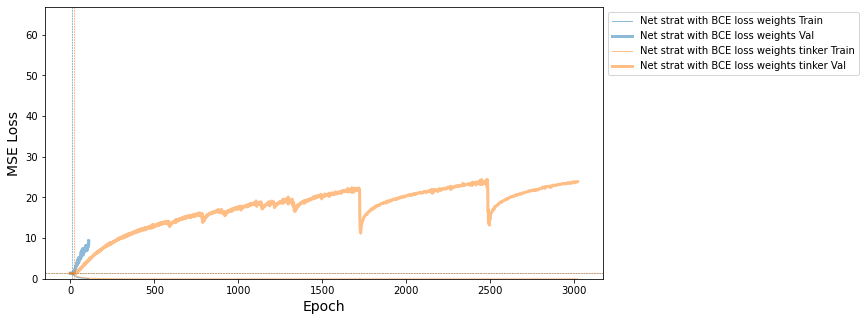

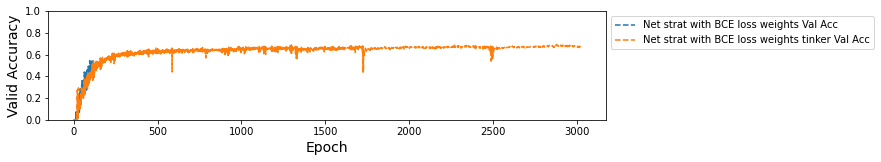

In [43]:
nets = [
    #(net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights'),
#     (net_strat_bcew_tink,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink2,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink3,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink4,'Net strat with BCE loss weights tinker'),
    (net_strat_bcew_tink5,'Net strat with BCE loss weights tinker'),
]


sk_loss_plot(nets,yscaler=50)

In [44]:
cls_full_train_df = view_cls_report(net_strat_bcew_tink5,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew_tink5,Xval_strat,yval_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew_tink5,Xtest_strat,ytest_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [54]:
#plot_confusion_multi([(net_strat_bcew_tink5,'bce weight tinkering')], Xtrain_strat,ytrain_strat,imods_filt)

In [41]:
#plot_confusion_multi([(net_strat_bcew_tink4,'bce weight tinkering')], Xval_strat,yval_strat,imods_filt)

In [42]:
#plot_confusion_multi([(net_strat_bcew_tink4,'bce weight tinkering')], Xtest_strat,ytest_strat,imods_filt)

In [43]:
net_strat_bcew_tink5.get_params()

{'module': models.DNA_2CNN_2FC_Multi,
 'criterion': BCEWithLogitsLoss(),
 'optimizer': torch.optim.adamw.AdamW,
 'lr': 0.0001,
 'max_epochs': 2000,
 'batch_size': 256,
 'iterator_train': torch.utils.data.dataloader.DataLoader,
 'iterator_valid': torch.utils.data.dataloader.DataLoader,
 'dataset': skorch.dataset.Dataset,
 'train_split': functools.partial(<function _make_split at 0x7f992046b0e0>, valid_ds=<skorch.dataset.Dataset object at 0x7f98c3a9e0d0>),
 'callbacks': [<skorch.callbacks.training.EarlyStopping at 0x7f985c3bd390>,
 'predict_nonlinearity': 'auto',
 'warm_start': False,
 'verbose': 1,
 'device': device(type='cuda'),
 '_kwargs': {'module__seq_len': 300,
  'module__n_tasks': 58,
  'module__num_filters1': 64,
  'module__num_filters2': 8,
  'module__kernel_size1': 8,
  'module__kernel_size2': 3,
  'module__conv_pool_size1': 3,
  'module__conv_pool_size2': 1,
  'module__fc_node_num1': 50,
  'module__fc_node_num2': 50,
  'module__dropout1': 0.2,
  'module__dropout2': 0.4,
  'opt

# SKORCH search

In [45]:
from sklearn.model_selection import RandomizedSearchCV


In [46]:
valid_ds = Dataset(Xval_strat, yval_strat)

net_search = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    #train_split=ValidSplit(0.2),
    #train_split=None,
    #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
    #train_split=k_fold,
    train_split=predefined_split(valid_ds),
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=3000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         #EarlyStopping(patience=100),
         EarlyStopping(patience=1000),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)


In [47]:
params = {
    'lr': [0.001, 0.0005, 0.0001,],#loguniform(0.0001, 0.01)
    'batch_size':[32,64,128,256],
    'module__num_filters1': [32,64,128,256],
    'module__num_filters2': [32,64,128],
    'module__kernel_size1': [8,16,32],
    'module__kernel_size2': [8,16,32],
    'module__conv_pool_size1': [2,3],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer':[torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [50]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=1000, 
    #scoring='neg_mean_squared_error', 
    #scoring=['precision','recall','f1_macro'], 
    scoring=['f1_macro'], 
    refit='f1_macro',
    n_jobs=-1, 
    cv=3,#cv, 
    #cv=k_fold.split(Xtrain_strat,ytrain_strat),
    #cv=k_fold,
    random_state=7,
    verbose=1
)

In [ ]:
search.fit(Xtrain_strat,ytrain_strat)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 181.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 457.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 792.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 1236.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 1796.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 2420.1min


In [53]:
1+3

4

In [55]:
search.cv_results_

{'mean_fit_time': array([ 174.07894079,   83.88609799,  295.32869077,  286.08445581,
         193.30905135,  114.03280417,  256.35039822,   92.50197872,
         131.08863688,   96.70305689,  120.39569887,  125.452003  ,
         307.22088798,  151.2880408 ,  289.23950553,  134.64663959,
         333.61997493,  241.0977385 ,  228.69053046,  261.78293395,
         145.68463524,  499.0533514 ,  155.42702905,  293.57449309,
         300.49766954,  134.76461673,  453.64425882,  125.92694068,
         143.39413913,  136.78186544,  196.27306   ,  215.54068915,
         473.94807347,  416.01729608,  249.6036977 ,  204.88969096,
          94.53324032,  160.07969507,  588.62135243,  213.8236773 ,
         471.72423824,  284.73614057,  191.2986335 ,  171.72488268,
         284.13786681,  107.72890178,  181.56782587,  317.22650735,
         184.29096103,  162.16202561,  224.37885873,  118.94939613,
         291.55802298,  189.36642027,  345.283892  ,  144.73310773,
         273.08628289,  180.039

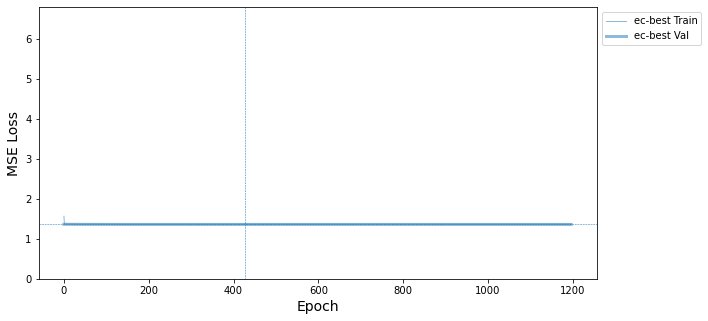

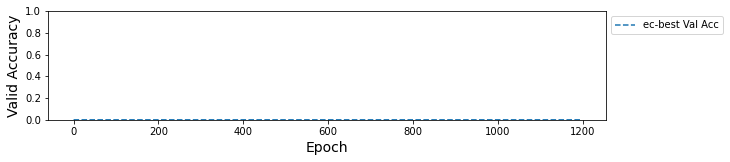

In [58]:
netss = [
    #(net_randsplit,"RandSplit"),
    #(net_strat_bcew_tink5,"StratSplit5"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(netss)

### inspect hyperparam search results

In [59]:
search.best_estimator_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 256, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.0, inplace=False)
      (4): Conv2d(256, 128, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.0, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=17792, out_features=500, bias=True)
      (9): ReLU()
      (10): Linear(in_features=500, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=15, bias=True)
    )
  ),
)

In [60]:
search.best_params_

{'optimizer': torch.optim.rmsprop.RMSprop,
 'module__num_filters2': 128,
 'module__num_filters1': 256,
 'module__kernel_size2': 8,
 'module__kernel_size1': 8,
 'module__fc_node_num2': 10,
 'module__fc_node_num1': 500,
 'module__dropout2': 0.0,
 'module__dropout1': 0.0,
 'module__conv_pool_size1': 2,
 'lr': 0.0005,
 'batch_size': 64}

In [61]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       174.078941      3.055924         0.036090        0.006722   
1        83.886098     11.036187         0.018459        0.000425   
2       295.328691      2.136481         0.047441        0.004097   
3       286.084456      0.462509         0.038869        0.006066   
4       193.309051      0.868605         0.026572        0.001879   
..             ...           ...              ...             ...   
995     136.523441      5.103961         0.023055        0.001362   
996     433.902389     98.855534         0.056283        0.005334   
997     340.599303     12.392051         0.048607        0.002753   
998     189.293604      5.674480         0.042487        0.003305   
999     143.547474      8.072270         0.015087        0.003057   

                           param_optimizer param_module__num_filters2  \
0    <class 'torch.optim.rmsprop.RMSprop'>                         32   
1            <class 'torch.optim.sgd.SGD'>                         64   
2          <class 'torch.optim.adam.Adam'>                         64   
3        <class 'torch.optim.adamw.AdamW'>                        128   
4    <class 'torch.optim.rmsprop.RMSprop'>                        128   
..                                     ...                        ...   
995          <class 'torch.optim.sgd.SGD'>                        128   
996          <class 'torch.optim.sgd.SGD'>                         32   
997  <class 'torch.optim.rmsprop.RMSprop'>                         64   
998          <class 'torch.optim.sgd.SGD'>                         32   
999  <class 'torch.optim.rmsprop.RMSprop'>                        128   

    param_module__num_filters1 param_module__kernel_size2  \
0                           64                         32   
1                           32                         32   
2                          256                         32   
3                           64                         16   
4                          128                         16   
..                         ...                        ...   
995                         64                          8   
996                        256                         16   
997                        128                         16   
998                        128                         16   
999                         64                         16   

    param_module__kernel_size1 param_module__fc_node_num2  ... param_lr  \
0                            8                         10  ...   0.0005   
1                            8                        100  ...    0.001   
2                           16                         10  ...   0.0005   
3                           16                        100  ...   0.0005   
4                            8                         10  ...    0.001   
..                         ...                        ...  ...      ...   
995                         16                         50  ...   0.0005   
996                         16                         50  ...    0.001   
997                         16                        500  ...   0.0005   
998                         16                         50  ...    0.001   
999                          8                         10  ...    0.001   

    param_batch_size                                             params  \
0                 64  {'optimizer': <class 'torch.optim.rmsprop.RMSp...   
1                256  {'optimizer': <class 'torch.optim.sgd.SGD'>, '...   
2                 64  {'optimizer': <class 'torch.optim.adam.Adam'>,...   
3                 64  {'optimizer': <class 'torch.optim.adamw.AdamW'...   
4                128  {'optimizer': <class 'torch.optim.rmsprop.RMSp...   
..               ...                                                ...   
995              256  {'optimizer': <class 'torch.optim.sgd.SGD'>, '...   
996               32  {'optimizer': <class 'torch.optim.sgd.SGD'>

In [62]:
sm_res_df = res_df[[
    "rank_test_f1_macro",
    "mean_test_f1_macro",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [63]:
sm_res_df

rank_test_f1_macro  mean_test_f1_macro param_module__num_filters1  \
0                   511            0.010124                         64   
1                   503            0.010224                         32   
2                   412            0.010963                        256   
3                   778            0.004938                         64   
4                   746            0.005908                        128   
..                  ...                 ...                        ...   
995                 545            0.009781                         64   
996                  17            0.024743                        256   
997                 245            0.012516                        128   
998                 385            0.011256                        128   
999                 215            0.012903                         64   

    param_module__num_filters2 param_module__kernel_size1  \
0                           32                          8   
1                           64                          8   
2                           64                         16   
3                          128                         16   
4                          128                          8   
..                         ...                        ...   
995                        128                         16   
996                         32                         16   
997                         64                         16   
998                         32                         16   
999                        128                          8   

    param_module__kernel_size2 param_lr param_module__fc_node_num1  \
0                           32   0.0005                        500   
1                           32    0.001                         10   
2                           32   0.0005                         10   
3                           16   0.0005                         50   
4                           16    0.001                        100   
..                         ...      ...                        ...   
995                          8   0.0005                         50   
996                         16    0.001                        500   
997                         16   0.0005                        500   
998                         16    0.001                        100   
999                         16    0.001                         10   

    param_module__fc_node_num2 opt_name  
0                           10  RMSprop  
1                          100      SGD  
2                           10     Adam  
3                          100    AdamW  
4                           10  RMSprop  
..                         ...      ...  
995                         50      SGD  
996                         50      SGD  
997                        500  RMSprop  
998                         50      SGD  
999                         10  RMSprop  

[1000 rows x 10 columns]

In [64]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_f1_macro:Q',
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [65]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_f1_macro:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [66]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [67]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [68]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [69]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [70]:
res_df.to_csv('ec_iMod_out/hyper_clf_weightedLoss.tsv',sep='\t',index=False)

In [71]:
# best estimator predictions
cls_full_train_df = view_cls_report(search.best_estimator_,Xtrain_strat,ytrain_strat,imods_filt)
cls_full_val_df = view_cls_report(search.best_estimator_,Xval_strat,yval_strat,imods_filt)
cls_full_test_df = view_cls_report(search.best_estimator_,Xtest_strat,ytest_strat,imods_filt)


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

Running searchbest train


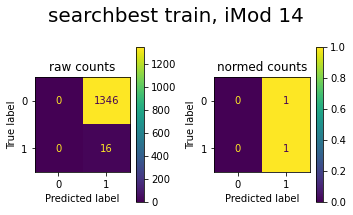

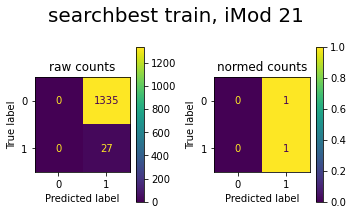

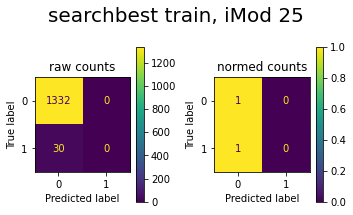

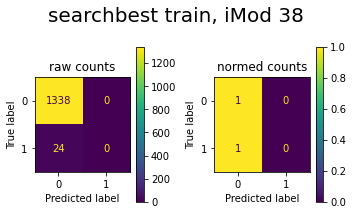

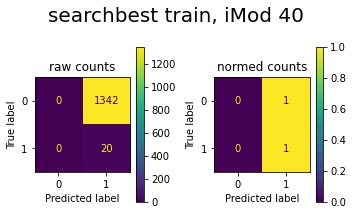

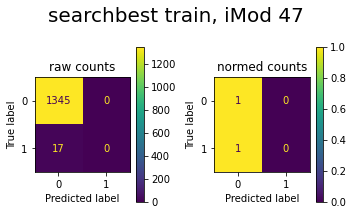

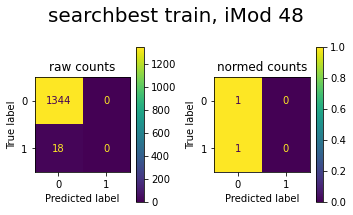

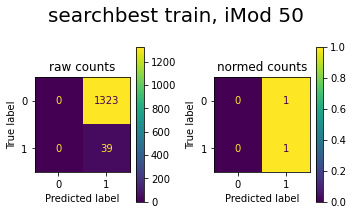

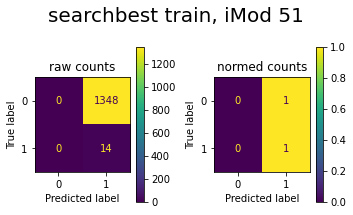

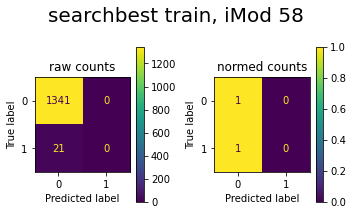

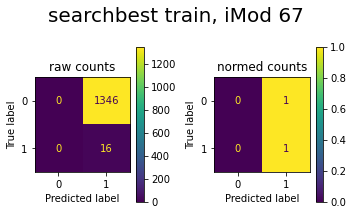

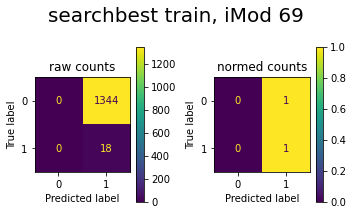

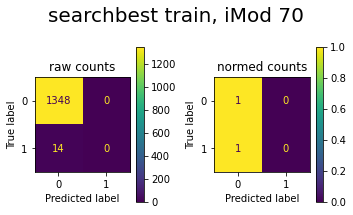

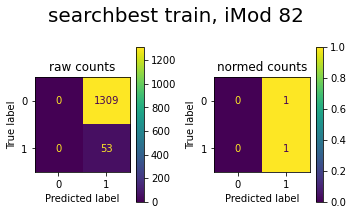

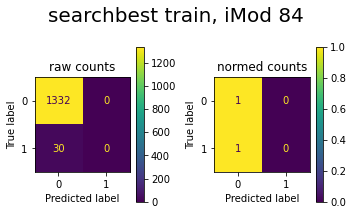

In [72]:
plot_confusion_multi([(search.best_estimator_,'searchbest train')], Xtrain_strat,ytrain_strat,imods_filt)

Running searchbest val


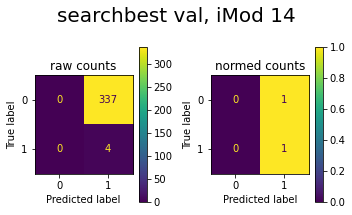

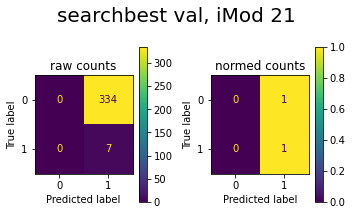

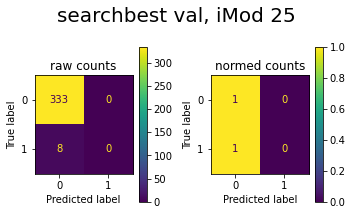

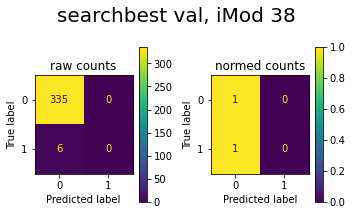

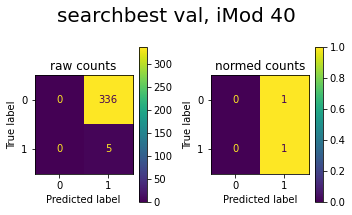

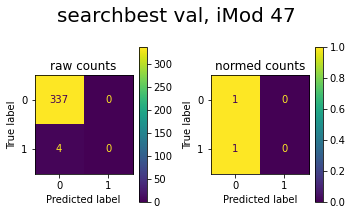

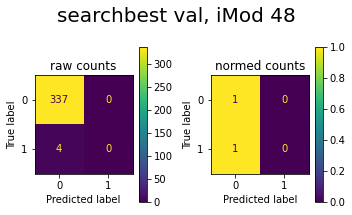

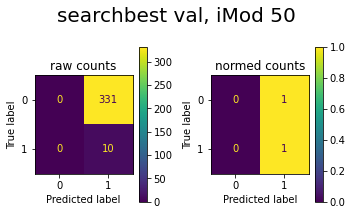

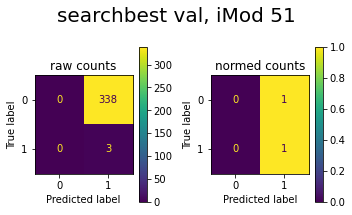

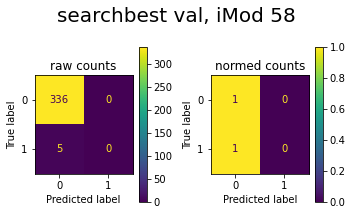

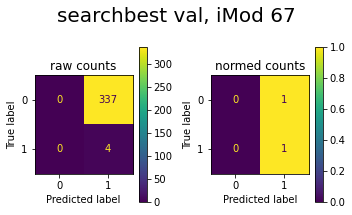

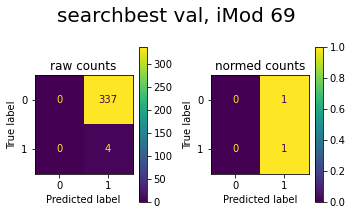

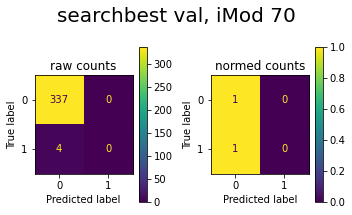

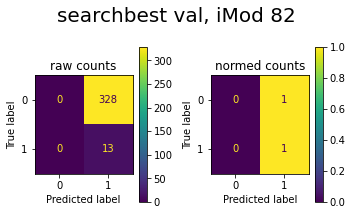

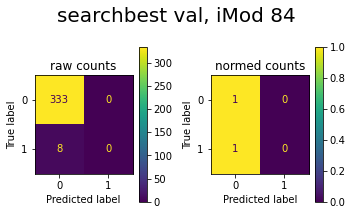

In [73]:
plot_confusion_multi([(search.best_estimator_,'searchbest val')], Xval_strat,yval_strat,imods_filt)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [74]:
net_cvp = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        #train_split=ValidSplit(0.2),
        #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
        train_split=None,
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
        module__dropout1 = 0.2,
        module__dropout2 = 0.2,
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=200,monitor='train_loss'),
             # suggested monitoring train loss when i want to do gridsearchcv with early stop?
             # https://github.com/skorch-dev/skorch/issues/837
             #Checkpoint(load_best=True),
             GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None,
        verbose=1
    )

In [75]:
from sklearn.model_selection import cross_val_predict

In [76]:
y_pred = cross_val_predict(net_cvp, Xtrain_strat, ytrain_strat, cv=5)

# these instructions for using skorch with cross_val_predict don't work
# https://skorch.readthedocs.io/en/latest/user/dataset.html?highlight=fold#validsplit

# when train_split=None, then "valid loss" is not in history
# when train_split is left default, it says StratifiedCV needs a suitable y

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5955  0.0902
      2        0.1069  0.0893
      3        0.0700  0.0672
      4        0.0555  0.0666
      5        0.0519  0.0659
      6        0.0500  0.0603
      7        0.0489  0.0582
      8        0.0483  0.0583
      9        0.0483  0.0579
     10        0.0482  0.0589
     11        0.0484  0.0579
     12        0.0480  0.0546
     13        0.0482  0.0576
     14        0.0481  0.0568
     15        0.0482  0.0570
     16        0.0481  0.0566
     17        0.0478  0.0570
     18        0.0479  0.0573
     19        0.0480  0.0577
     20        0.0482  0.0584
     21        0.0480  0.0583
     22        0.0474  0.0579
     23        0.0474  0.0584
     24        0.0475  0.0580
     25        0.0473  0.0587
     26        0.0475  0.0579
     27        0.0471  0.0580
     28        0.0468  0.0579
     29        0.0467  0.0580
     30        0.0475  0.0579
     31        0.0467  0.0579
     32   

    241        0.0040  0.0555
    242        0.0042  0.0554
    243        0.0048  0.0555
    244        0.0046  0.0555
    245        0.0056  0.0559
    246        0.0044  0.0558
    247        0.0041  0.0557
    248        0.0039  0.0556
    249        0.0042  0.0562
    250        0.0039  0.0563
    251        0.0050  0.0559
    252        0.0035  0.0559
    253        0.0051  0.0562
    254        0.0055  0.0564
    255        0.0051  0.0559
    256        0.0049  0.0558
    257        0.0048  0.0556
    258        0.0043  0.0556
    259        0.0032  0.0557
    260        0.0041  0.0557
    261        0.0041  0.0561
    262        0.0053  0.0556
    263        0.0037  0.0556
    264        0.0036  0.0555
    265        0.0048  0.0558
    266        0.0035  0.0559
    267        0.0043  0.0559
    268        0.0038  0.0556
    269        0.0039  0.0556
    270        0.0046  0.0557
    271        0.0048  0.0559
    272        0.0034  0.0561
    273        0.0041  0.0560
    274   

    512        0.0060  0.0582
    513        0.0043  0.0582
    514        0.0047  0.0585
    515        0.0046  0.0586
    516        0.0044  0.0578
    517        0.0053  0.0577
    518        0.0054  0.0579
    519        0.0048  0.0578
    520        0.0041  0.0576
    521        0.0032  0.0577
    522        0.0041  0.0578
    523        0.0040  0.0577
    524        0.0043  0.0577
    525        0.0036  0.0575
    526        0.0025  0.0576
    527        0.0043  0.0575
    528        0.0034  0.0576
    529        0.0039  0.0573
    530        0.0046  0.0574
    531        0.0039  0.0578
    532        0.0045  0.0575
    533        0.0029  0.0576
    534        0.0039  0.0578
    535        0.0039  0.0578
    536        0.0041  0.0576
    537        0.0043  0.0579
    538        0.0040  0.0577
    539        0.0043  0.0580
    540        0.0049  0.0576
    541        0.0033  0.0578
    542        0.0047  0.0575
    543        0.0041  0.0576
    544        0.0037  0.0579
    545   

      2        0.1280  0.0578
      3        0.0697  0.0594
      4        0.0581  0.0584
      5        0.0525  0.0580
      6        0.0507  0.0581
      7        0.0489  0.0585
      8        0.0486  0.0586
      9        0.0484  0.0581
     10        0.0486  0.0574
     11        0.0481  0.0575
     12        0.0482  0.0577
     13        0.0481  0.0576
     14        0.0482  0.0573
     15        0.0485  0.0574
     16        0.0485  0.0574
     17        0.0478  0.0576
     18        0.0482  0.0569
     19        0.0481  0.0574
     20        0.0480  0.0579
     21        0.0478  0.0576
     22        0.0475  0.0566
     23        0.0476  0.0555
     24        0.0475  0.0558
     25        0.0473  0.0559
     26        0.0474  0.0559
     27        0.0473  0.0555
     28        0.0472  0.0555
     29        0.0471  0.0557
     30        0.0468  0.0565
     31        0.0470  0.0551
     32        0.0469  0.0552
     33        0.0466  0.0551
     34        0.0467  0.0555
     35   

    242        0.0029  0.0555
    243        0.0029  0.0556
    244        0.0027  0.0556
    245        0.0029  0.0557
    246        0.0034  0.0575
    247        0.0027  0.0585
    248        0.0036  0.0589
    249        0.0029  0.0586
    250        0.0045  0.0586
    251        0.0036  0.0584
    252        0.0033  0.0584
    253        0.0038  0.0585
    254        0.0037  0.0588
    255        0.0043  0.0583
    256        0.0034  0.0582
    257        0.0040  0.0584
    258        0.0032  0.0585
    259        0.0036  0.0592
    260        0.0036  0.0593
    261        0.0031  0.0587
    262        0.0031  0.0586
    263        0.0027  0.0583
    264        0.0032  0.0579
    265        0.0025  0.0589
    266        0.0033  0.0585
    267        0.0037  0.0584
    268        0.0032  0.0582
    269        0.0038  0.0585
    270        0.0032  0.0580
    271        0.0047  0.0579
    272        0.0038  0.0571
    273        0.0037  0.0571
    274        0.0026  0.0579
    275   

    514        0.0042  0.0586
    515        0.0042  0.0590
    516        0.0031  0.0592
    517        0.0031  0.0587
    518        0.0047  0.0586
    519        0.0042  0.0583
    520        0.0038  0.0592
    521        0.0042  0.0591
    522        0.0033  0.0586
    523        0.0045  0.0587
    524        0.0041  0.0585
    525        0.0047  0.0587
    526        0.0037  0.0594
    527        0.0053  0.0584
    528        0.0041  0.0586
    529        0.0057  0.0587
    530        0.0039  0.0585
    531        0.0032  0.0586
    532        0.0023  0.0586
    533        0.0026  0.0587
    534        0.0026  0.0583
    535        0.0034  0.0589
    536        0.0038  0.0586
    537        0.0031  0.0590
    538        0.0040  0.0587
    539        0.0038  0.0584
    540        0.0027  0.0589
    541        0.0038  0.0585
    542        0.0063  0.0586
    543        0.0039  0.0587
    544        0.0051  0.0585
    545        0.0041  0.0582
    546        0.0045  0.0584
    547   

     89        0.0056  0.0551
     90        0.0052  0.0551
     91        0.0049  0.0548
     92        0.0048  0.0550
     93        0.0050  0.0545
     94        0.0044  0.0563
     95        0.0047  0.0550
     96        0.0043  0.0551
     97        0.0035  0.0552
     98        0.0034  0.0552
     99        0.0031  0.0551
    100        0.0030  0.0551
    101        0.0037  0.0552
    102        0.0028  0.0551
    103        0.0031  0.0551
    104        0.0028  0.0552
    105        0.0029  0.0551
    106        0.0033  0.0549
    107        0.0039  0.0550
    108        0.0035  0.0552
    109        0.0042  0.0556
    110        0.0036  0.0553
    111        0.0048  0.0552
    112        0.0035  0.0551
    113        0.0039  0.0551
    114        0.0031  0.0551
    115        0.0031  0.0551
    116        0.0037  0.0552
    117        0.0030  0.0546
    118        0.0026  0.0575
    119        0.0036  0.0574
    120        0.0031  0.0564
    121        0.0031  0.0561
    122   

    357        0.0020  0.0571
    358        0.0035  0.0572
    359        0.0029  0.0571
    360        0.0024  0.0572
    361        0.0021  0.0584
    362        0.0020  0.0577
    363        0.0022  0.0575
    364        0.0028  0.0577
    365        0.0036  0.0577
    366        0.0032  0.0560
    367        0.0043  0.0559
    368        0.0022  0.0560
    369        0.0033  0.0563
    370        0.0038  0.0560
    371        0.0020  0.0558
    372        0.0036  0.0557
    373        0.0049  0.0556
    374        0.0041  0.0558
    375        0.0044  0.0561
    376        0.0064  0.0560
    377        0.0059  0.0559
    378        0.0059  0.0560
    379        0.0042  0.0561
    380        0.0051  0.0558
    381        0.0052  0.0560
    382        0.0042  0.0554
    383        0.0030  0.0555
    384        0.0035  0.0554
    385        0.0041  0.0564
    386        0.0036  0.0562
    387        0.0028  0.0562
    388        0.0035  0.0559
    389        0.0036  0.0559
    390   

    190        0.0028  0.0550
    191        0.0032  0.0549
    192        0.0040  0.0550
    193        0.0034  0.0549
    194        0.0035  0.0549
    195        0.0041  0.0547
    196        0.0037  0.0547
    197        0.0040  0.0549
    198        0.0045  0.0548
    199        0.0045  0.0548
    200        0.0046  0.0549
    201        0.0044  0.0547
    202        0.0046  0.0546
    203        0.0043  0.0546
    204        0.0040  0.0547
    205        0.0040  0.0547
    206        0.0052  0.0549
    207        0.0050  0.0546
    208        0.0041  0.0548
    209        0.0034  0.0548
    210        0.0032  0.0550
    211        0.0031  0.0552
    212        0.0037  0.0550
    213        0.0037  0.0550
    214        0.0037  0.0550
    215        0.0032  0.0549
    216        0.0038  0.0550
    217        0.0042  0.0550
    218        0.0036  0.0549
    219        0.0032  0.0549
    220        0.0030  0.0548
    221        0.0039  0.0547
    222        0.0038  0.0550
    223   

    461        0.0025  0.0549
    462        0.0020  0.0549
    463        0.0019  0.0547
    464        0.0024  0.0548
    465        0.0017  0.0552
    466        0.0022  0.0554
    467        0.0028  0.0553
    468        0.0037  0.0551
    469        0.0029  0.0551
    470        0.0032  0.0550
    471        0.0034  0.0550
    472        0.0052  0.0550
    473        0.0050  0.0551
    474        0.0030  0.0551
    475        0.0040  0.0551
    476        0.0043  0.0550
    477        0.0029  0.0550
    478        0.0028  0.0549
    479        0.0032  0.0546
    480        0.0035  0.0548
    481        0.0042  0.0548
    482        0.0025  0.0549
    483        0.0037  0.0550
    484        0.0036  0.0550
    485        0.0038  0.0550
    486        0.0040  0.0548
    487        0.0035  0.0550
    488        0.0036  0.0550
    489        0.0021  0.0553
    490        0.0033  0.0552
    491        0.0029  0.0550
    492        0.0029  0.0551
    493        0.0032  0.0553
    494   

    187        0.0349  0.0550
    188        0.0349  0.0550
    189        0.0349  0.0551
    190        0.0349  0.0550
    191        0.0351  0.0551
    192        0.0349  0.0551
    193        0.0351  0.0552
    194        0.0350  0.0551
    195        0.0350  0.0549
    196        0.0350  0.0550
    197        0.0349  0.0556
    198        0.0348  0.0554
    199        0.0350  0.0557
    200        0.0350  0.0553
    201        0.0349  0.0550
    202        0.0349  0.0550
    203        0.0349  0.0549
    204        0.0349  0.0548
    205        0.0349  0.0549
    206        0.0349  0.0550
    207        0.0350  0.0549
    208        0.0349  0.0547
    209        0.0349  0.0551
    210        0.0349  0.0550
    211        0.0349  0.0552
    212        0.0348  0.0551
    213        0.0348  0.0549
    214        0.0349  0.0550
    215        0.0348  0.0548
    216        0.0349  0.0548
    217        0.0349  0.0548
Stopping since train_loss has not improved in the last 200 epochs.


In [77]:
netts = [
    #(search.best_estimator_,'ec-best_oldarch'),
    (net_cvp, 'manual cvp?')
]

sk_loss_plot(netts)

# errors because cross_val_predict doesn't actually train the model...?

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>

In [78]:
net_cvp

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__conv_pool_size1=3,
  module__conv_pool_size2=1,
  module__dropout1=0.2,
  module__dropout2=0.2,
  module__fc_node_num1=100,
  module__fc_node_num2=100,
  module__kernel_size1=8,
  module__kernel_size2=8,
  module__n_tasks=58,
  module__num_filters1=128,
  module__num_filters2=64,
  module__seq_len=300,
)

In [79]:
y_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [80]:
def view_cls_report2(yt,yp,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the classification report
    cls_rep = classification_report(yt, yp,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df

In [81]:
# from cross_val_predict preds
view_cls_report2(ytrain_strat,y_pred,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

imod  precision  recall  f1-score  support
0      0        0.0     0.0       0.0        6
1      1        0.0     0.0       0.0        3
2      2        0.0     0.0       0.0        4
3      5        0.0     0.0       0.0        6
4      7        0.0     0.0       0.0        4
5      8        0.0     0.0       0.0        6
6     10        0.0     0.0       0.0        5
7     11        0.0     0.0       0.0        5
8     12        0.0     0.0       0.0        4
9     13        0.0     0.0       0.0        5
10    14        0.0     0.0       0.0       16
11    16        0.0     0.0       0.0        7
12    17        0.0     0.0       0.0        7
13    19        0.0     0.0       0.0        8
14    21        0.0     0.0       0.0       27
15    22        0.0     0.0       0.0        3
16    25        0.0     0.0       0.0       30
17    28        0.0     0.0       0.0        4
18    29        0.0     0.0       0.0        5
19    30        0.0     0.0       0.0        6
20    31        0.0     0.0       0.0       10
21    34        0.0     0.0       0.0        4
22    38        0.0     0.0       0.0       24
23    39        0.0     0.0       0.0        5
24    40        0.0     0.0       0.0       20
25    41        0.0     0.0       0.0        4
26    42        0.0     0.0       0.0        4
27    44        0.0     0.0       0.0        8
28    45        0.0     0.0       0.0       10
29    47        0.0     0.0       0.0       17
30    48        0.0     0.0       0.0       18
31    50        0.0     0.0       0.0       39
32    51        0.0     0.0       0.0       14
33    54        0.0     0.0       0.0        8
34    55        0.0     0.0       0.0        8
35    58        0.0     0.0       0.0       21
36    59        0.0     0.0       0.0        7
37    61        0.0     0.0       0.0       11
38    63        0.0     0.0       0.0        6
39    64        0.0     0.0       0.0        7
40    65        0.0     0.0       0.0        8
41    66        0.0     0.0       0.0        8
42    67        0.0     0.0       0.0       16
43    68        0.0     0.0       0.0        5
44    69        0.0     0.0       0.0       18
45    70        0.0     0.0       0.0       14
46    71        0.0     0.0       0.0        4
47    75        0.0     0.0       0.0        8
48    76        0.0     0.0       0.0        5
49    77        0.0     0.0       0.0        7
50    78        0.0     0.0       0.0        8
51    79        0.0     0.0       0.0        9
52    80        0.0     0.0       0.0        5
53    82        0.0     0.0       0.0       53
54    83        0.0     0.0       0.0        4
55    84        0.0     0.0       0.0       30
56    86        0.0     0.0       0.0        6
57    88        0.0     0.0       0.0        5

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


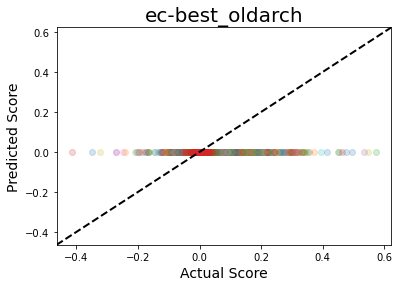

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

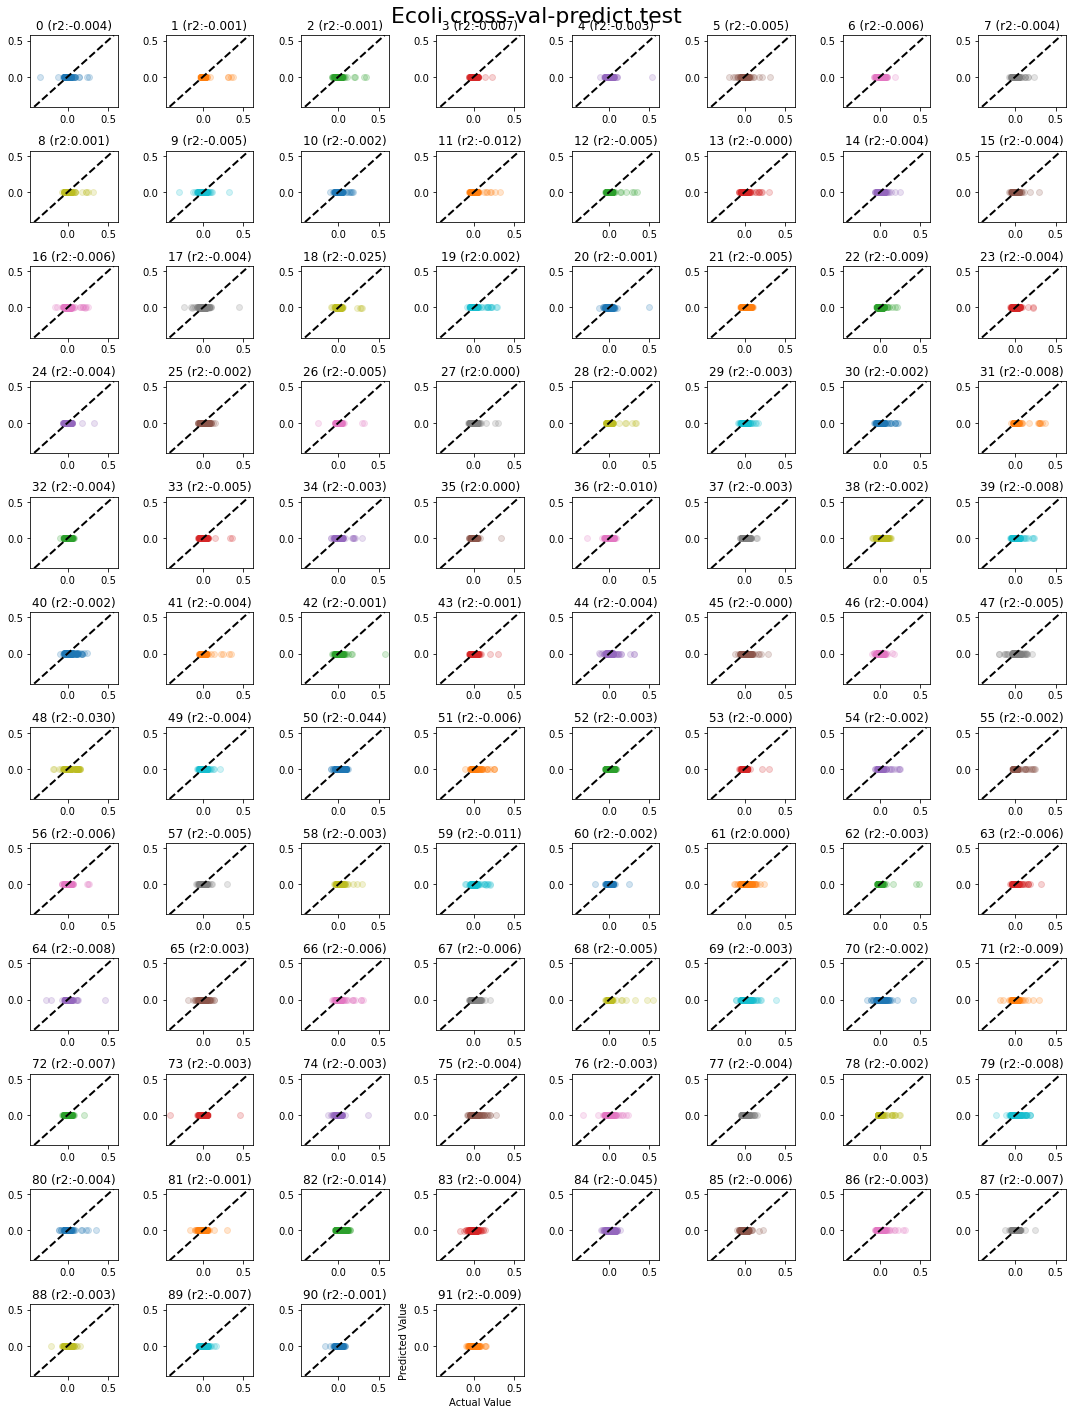

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one